In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

/var/folders/d8/t2gjvqln35zbh9nzb6yb_0cc0000gn/T/ipykernel_9852/1895431338.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
classes_found = base.classes.keys()
print(classes_found)

['measurement', 'station']


In [7]:
# Save references to each table
station = base.classes.station
measurement = base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
print(most_recent_date)

2017-08-23


In [11]:
#import and_
from sqlalchemy import and_

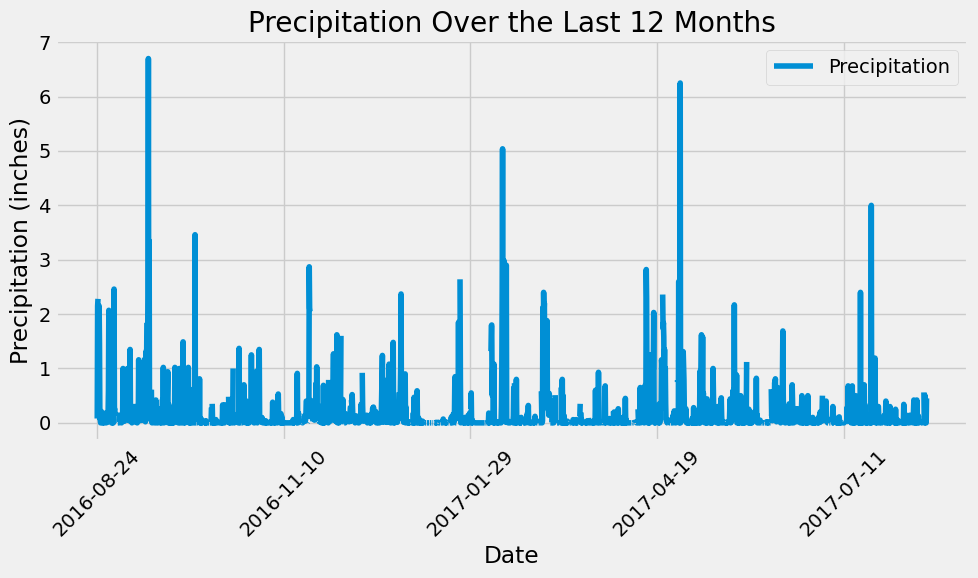

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(measurement.date)).scalar()
# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp)\
    .filter(and_(measurement.date >= one_year_ago, measurement.date <= most_recent_date))\
    .order_by(measurement.date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(10, 6), legend=True)
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()
print(summary_statistics)

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
print(total_stations)

9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc())\
    .all()
# List the stations and their counts in descending order.
for station, count in most_active_stations:
    print(f"Station ID: {station}, Observations Count: {count}")

Station ID: USC00519281, Observations Count: 2772
Station ID: USC00519397, Observations Count: 2724
Station ID: USC00513117, Observations Count: 2709
Station ID: USC00519523, Observations Count: 2669
Station ID: USC00516128, Observations Count: 2612
Station ID: USC00514830, Observations Count: 2202
Station ID: USC00511918, Observations Count: 1979
Station ID: USC00517948, Observations Count: 1372
Station ID: USC00518838, Observations Count: 511


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
    .filter(measurement.station == most_active_station_id)\
    .all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(lowest_temp, highest_temp, avg_temp)

54.0 85.0 71.66378066378067


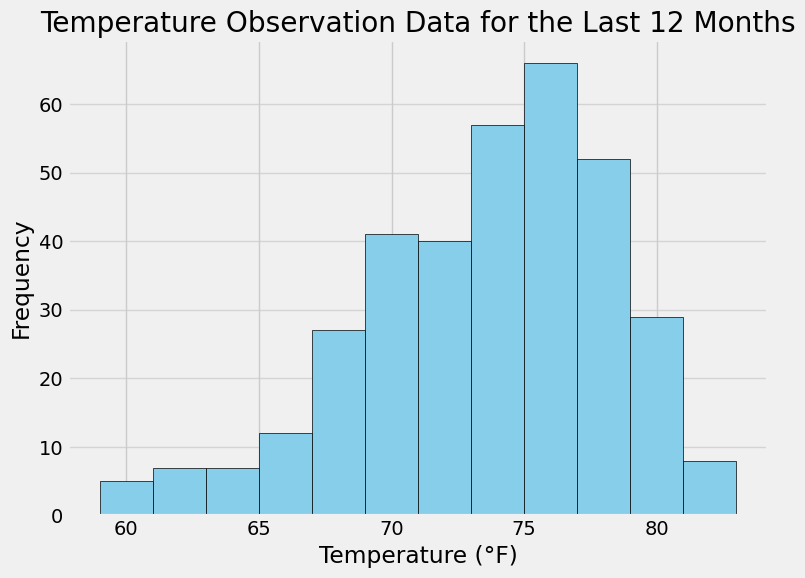

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(measurement.tobs)\
    .filter(and_(measurement.station == most_active_station_id, measurement.date >= one_year_ago, measurement.date <= most_recent_date))\
    .all()

#df
tobs_df = pd.DataFrame(tobs_data, columns=['Temperature'])

#histogram
plt.figure(figsize=(8, 6))
plt.hist(tobs_df['Temperature'], bins=12, color='skyblue', edgecolor='black')
plt.title('Temperature Observation Data for the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# Close Session

In [21]:
# Close Session
session.close()